In [1]:
import numpy as np
import pandas as pd
import torch
from config import load_config
from pathlib import Path
from lightning.pytorch.loggers.wandb import WandbLogger
from scipy.stats import wasserstein_distance, entropy
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
from umap import UMAP
from matplotlib import pyplot as plt
import seaborn as sns
import faiss

# initialize the RNG deterministically
np.random.seed(42)
torch.manual_seed(42)
torch.set_float32_matmul_precision('medium')

In [2]:
# parameters
dataset_name = ""
model_name = "flow_ss_vcr_mse"
ood = ""

In [3]:
# Parameters
dataset_name = "MNIST"
ood = "0:1:2:3:4"


In [4]:
# initialize data attributes and loaders
config = load_config(
    dataset_name = dataset_name,
    model_name = model_name,
    ood = ood,
)
config.load_data()
config.print_labels()
dm = config.datamodule

assert dm

  0%|                                                                                                                                                             | 0/60000 [00:00<?, ?it/s]

 12%|█████████████████▏                                                                                                                             | 7216/60000 [00:00<00:00, 72155.77it/s]

 24%|██████████████████████████████████▏                                                                                                           | 14432/60000 [00:00<00:00, 71711.76it/s]

 36%|███████████████████████████████████████████████████▏                                                                                          | 21608/60000 [00:00<00:00, 71730.79it/s]

 48%|████████████████████████████████████████████████████████████████████                                                                          | 28782/60000 [00:00<00:00, 71451.49it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████                                                         | 35964/60000 [00:00<00:00, 71582.79it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 43130/60000 [00:00<00:00, 71605.93it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 50291/60000 [00:00<00:00, 69254.52it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 57365/60000 [00:00<00:00, 69714.38it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60000/60000 [00:00<00:00, 70158.38it/s]

  0%|                                                                                                                                                             | 0/10000 [00:00<?, ?it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 7053/10000 [00:00<00:00, 70525.53it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 68897.89it/s]

In [5]:
# initialize data modules
dm.setup("fit")
dm.setup("test")
dm.setup("predict")

In [6]:
# model ids
ood_str = ":".join(map(str, config.ood))
df = pd.read_csv("ids.csv").fillna("")
model_id = df[(df.dataset_name == dataset_name) & (df.model_name == model_name) & (df.ood == ood)].id.item()
print(ood_str, model_id)

0:1:2:3:4 mf83m6il


In [7]:
# load model and weights
model = config.get_model()
artifact_dir = WandbLogger.download_artifact(artifact=f"yasith/robustml/model-{model_id}:best")
model = model.__class__.load_from_checkpoint(Path(artifact_dir) / "model.ckpt", config=config)
model = model.cuda()
model.eval();

wandb:   1 of 1 files downloaded.  


In [8]:
# create data loaders
train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()
test_loader = dm.test_dataloader()
if ood_str:
    predict_loader = dm.predict_dataloader()

In [9]:
# forward pass
with torch.no_grad():
    trn_inp = []
    trn_e_u = []
    trn_e_v = []
    trn_rcn = []
    trn_tgt = []

    val_inp = []
    val_e_u = []
    val_e_v = []
    val_rcn = []
    val_tgt = []

    ind_inp = []
    ind_e_u = []
    ind_e_v = []
    ind_rcn = []
    ind_tgt = []

    if ood_str:
        ood_inp = []
        ood_e_u = []
        ood_e_v = []
        ood_rcn = []
        ood_tgt = []

    rnd_inp = []
    rnd_e_u = []
    rnd_e_v = []
    rnd_rcn = []

    # train set (ind)
    for batch_idx, batch in enumerate(tqdm(train_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
        trn_inp.extend(x.detach().cpu().numpy())
        trn_e_u.extend(e_u.detach().cpu().numpy())
        trn_e_v.extend(e_v.detach().cpu().numpy())
        trn_rcn.extend(rcn.detach().cpu().numpy())
        trn_tgt.extend(y.detach().cpu().numpy())
    print("train - OK")

    # val set (ind)
    for batch_idx, batch in enumerate(tqdm(val_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
        val_inp.extend(x.detach().cpu().numpy())
        val_e_u.extend(e_u.detach().cpu().numpy())
        val_e_v.extend(e_v.detach().cpu().numpy())
        val_rcn.extend(rcn.detach().cpu().numpy())
        val_tgt.extend(y.detach().cpu().numpy())
    print("val - OK")

    # test set (ind)
    for batch_idx, batch in enumerate(tqdm(test_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
        ind_inp.extend(x.detach().cpu().numpy())
        ind_e_u.extend(e_u.detach().cpu().numpy())
        ind_e_v.extend(e_v.detach().cpu().numpy())
        ind_rcn.extend(rcn.detach().cpu().numpy())
        ind_tgt.extend(y.detach().cpu().numpy())
    print("test InD - OK")

    # predict set (ood)
    if ood_str:
        for batch_idx, batch in enumerate(tqdm(predict_loader)):
            x, y, *_ = batch
            x = x.float().cuda()
            (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
            ood_inp.extend(x.detach().cpu().numpy())
            ood_e_u.extend(e_u.detach().cpu().numpy())
            ood_e_v.extend(e_v.detach().cpu().numpy())
            ood_rcn.extend(rcn.detach().cpu().numpy())
            ood_tgt.extend(y.detach().cpu().numpy())
        print("test OoD - OK")

    # random set
    rnd_set = torch.randn(100, config.batch_size, *config.input_shape)
    for batch_idx, batch in enumerate(tqdm(rnd_set)):
        x = batch
        x = x.float().cuda()
        (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
        rnd_inp.extend(x.detach().cpu().numpy())
        rnd_e_u.extend(e_u.detach().cpu().numpy())
        rnd_e_v.extend(e_v.detach().cpu().numpy())
        rnd_rcn.extend(rcn.detach().cpu().numpy())
    print("test RnD - OK")

  0%|                                                                                                                                                               | 0/184 [00:00<?, ?it/s]

  1%|▊                                                                                                                                                      | 1/184 [00:00<01:58,  1.55it/s]

  2%|██▍                                                                                                                                                    | 3/184 [00:00<00:37,  4.81it/s]

  3%|████                                                                                                                                                   | 5/184 [00:00<00:22,  7.78it/s]

  4%|█████▋                                                                                                                                                 | 7/184 [00:00<00:17, 10.34it/s]

  5%|███████▍                                                                                                                                               | 9/184 [00:01<00:14, 12.41it/s]

  6%|████████▉                                                                                                                                             | 11/184 [00:01<00:12, 14.03it/s]

  7%|██████████▌                                                                                                                                           | 13/184 [00:01<00:11, 15.25it/s]

  8%|████████████▏                                                                                                                                         | 15/184 [00:01<00:10, 16.15it/s]

  9%|█████████████▊                                                                                                                                        | 17/184 [00:01<00:09, 16.81it/s]

 10%|███████████████▍                                                                                                                                      | 19/184 [00:01<00:09, 17.28it/s]

 11%|█████████████████                                                                                                                                     | 21/184 [00:01<00:09, 17.62it/s]

 12%|██████████████████▊                                                                                                                                   | 23/184 [00:01<00:09, 17.88it/s]

 14%|████████████████████▍                                                                                                                                 | 25/184 [00:01<00:08, 18.05it/s]

 15%|██████████████████████                                                                                                                                | 27/184 [00:02<00:08, 18.15it/s]

 16%|███████████████████████▋                                                                                                                              | 29/184 [00:02<00:08, 18.23it/s]

 17%|█████████████████████████▎                                                                                                                            | 31/184 [00:02<00:08, 18.31it/s]

 18%|██████████████████████████▉                                                                                                                           | 33/184 [00:02<00:08, 18.35it/s]

 19%|████████████████████████████▌                                                                                                                         | 35/184 [00:02<00:08, 18.39it/s]

 20%|██████████████████████████████▏                                                                                                                       | 37/184 [00:02<00:07, 18.40it/s]

 21%|███████████████████████████████▊                                                                                                                      | 39/184 [00:02<00:07, 18.41it/s]

 22%|█████████████████████████████████▍                                                                                                                    | 41/184 [00:02<00:07, 18.42it/s]

 23%|███████████████████████████████████                                                                                                                   | 43/184 [00:02<00:07, 18.41it/s]

 24%|████████████████████████████████████▋                                                                                                                 | 45/184 [00:03<00:07, 18.42it/s]

 26%|██████████████████████████████████████▎                                                                                                               | 47/184 [00:03<00:07, 18.44it/s]

 27%|███████████████████████████████████████▉                                                                                                              | 49/184 [00:03<00:07, 18.45it/s]

 28%|█████████████████████████████████████████▌                                                                                                            | 51/184 [00:03<00:07, 18.46it/s]

 29%|███████████████████████████████████████████▏                                                                                                          | 53/184 [00:03<00:07, 18.46it/s]

 30%|████████████████████████████████████████████▊                                                                                                         | 55/184 [00:03<00:07, 18.36it/s]

 31%|██████████████████████████████████████████████▍                                                                                                       | 57/184 [00:03<00:06, 18.37it/s]

 32%|████████████████████████████████████████████████                                                                                                      | 59/184 [00:03<00:06, 18.41it/s]

 33%|█████████████████████████████████████████████████▋                                                                                                    | 61/184 [00:03<00:06, 18.43it/s]

 34%|███████████████████████████████████████████████████▎                                                                                                  | 63/184 [00:04<00:06, 18.44it/s]

 35%|████████████████████████████████████████████████████▉                                                                                                 | 65/184 [00:04<00:06, 18.43it/s]

 36%|██████████████████████████████████████████████████████▌                                                                                               | 67/184 [00:04<00:06, 18.45it/s]

 38%|████████████████████████████████████████████████████████▎                                                                                             | 69/184 [00:04<00:06, 18.45it/s]

 39%|█████████████████████████████████████████████████████████▉                                                                                            | 71/184 [00:04<00:06, 18.46it/s]

 40%|███████████████████████████████████████████████████████████▌                                                                                          | 73/184 [00:04<00:06, 18.45it/s]

 41%|█████████████████████████████████████████████████████████████▏                                                                                        | 75/184 [00:04<00:05, 18.46it/s]

 42%|██████████████████████████████████████████████████████████████▊                                                                                       | 77/184 [00:04<00:05, 18.47it/s]

 43%|████████████████████████████████████████████████████████████████▍                                                                                     | 79/184 [00:04<00:05, 18.47it/s]

 44%|██████████████████████████████████████████████████████████████████                                                                                    | 81/184 [00:04<00:05, 18.47it/s]

 45%|███████████████████████████████████████████████████████████████████▋                                                                                  | 83/184 [00:05<00:05, 18.47it/s]

 46%|█████████████████████████████████████████████████████████████████████▎                                                                                | 85/184 [00:05<00:05, 18.47it/s]

 47%|██████████████████████████████████████████████████████████████████████▉                                                                               | 87/184 [00:05<00:05, 18.48it/s]

 48%|████████████████████████████████████████████████████████████████████████▌                                                                             | 89/184 [00:05<00:05, 18.48it/s]

 49%|██████████████████████████████████████████████████████████████████████████▏                                                                           | 91/184 [00:05<00:05, 18.46it/s]

 51%|███████████████████████████████████████████████████████████████████████████▊                                                                          | 93/184 [00:05<00:04, 18.44it/s]

 52%|█████████████████████████████████████████████████████████████████████████████▍                                                                        | 95/184 [00:05<00:04, 18.44it/s]

 53%|███████████████████████████████████████████████████████████████████████████████                                                                       | 97/184 [00:05<00:04, 18.44it/s]

 54%|████████████████████████████████████████████████████████████████████████████████▋                                                                     | 99/184 [00:05<00:04, 18.45it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████▊                                                                   | 101/184 [00:06<00:04, 18.46it/s]

 56%|███████████████████████████████████████████████████████████████████████████████████▍                                                                 | 103/184 [00:06<00:04, 18.46it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████████                                                                | 105/184 [00:06<00:04, 18.46it/s]

 58%|██████████████████████████████████████████████████████████████████████████████████████▋                                                              | 107/184 [00:06<00:04, 18.45it/s]

 59%|████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 109/184 [00:06<00:04, 18.39it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                           | 111/184 [00:06<00:03, 18.42it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 113/184 [00:06<00:03, 18.44it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 115/184 [00:06<00:03, 18.45it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 117/184 [00:06<00:03, 18.46it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 119/184 [00:07<00:03, 18.46it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 121/184 [00:07<00:03, 18.45it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 123/184 [00:07<00:03, 18.46it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 125/184 [00:07<00:03, 18.46it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 127/184 [00:07<00:03, 18.47it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 129/184 [00:07<00:02, 18.47it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 131/184 [00:07<00:02, 18.47it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 133/184 [00:07<00:02, 18.47it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 135/184 [00:07<00:02, 18.41it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 137/184 [00:08<00:02, 18.42it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 139/184 [00:08<00:02, 18.44it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 141/184 [00:08<00:02, 18.46it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 143/184 [00:08<00:02, 18.46it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 145/184 [00:08<00:02, 18.47it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 147/184 [00:08<00:02, 18.47it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 149/184 [00:08<00:01, 18.48it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 151/184 [00:08<00:01, 18.48it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 153/184 [00:08<00:01, 18.48it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 155/184 [00:08<00:01, 18.47it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 157/184 [00:09<00:01, 18.47it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 159/184 [00:09<00:01, 18.48it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 161/184 [00:09<00:01, 18.47it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 163/184 [00:09<00:01, 18.47it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 165/184 [00:09<00:01, 18.46it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 167/184 [00:09<00:00, 18.44it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 169/184 [00:09<00:00, 18.44it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 171/184 [00:09<00:00, 18.45it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 173/184 [00:09<00:00, 18.46it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 175/184 [00:10<00:00, 18.45it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 177/184 [00:10<00:00, 18.44it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 179/184 [00:10<00:00, 18.47it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 181/184 [00:10<00:00, 18.48it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 183/184 [00:10<00:00, 18.50it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 184/184 [00:10<00:00, 17.37it/s]

train - OK


  0%|                                                                                                                                                                | 0/46 [00:00<?, ?it/s]

  2%|███▎                                                                                                                                                    | 1/46 [00:00<00:05,  7.96it/s]

  7%|█████████▉                                                                                                                                              | 3/46 [00:00<00:03, 13.71it/s]

 11%|████████████████▌                                                                                                                                       | 5/46 [00:00<00:02, 15.80it/s]

 15%|███████████████████████▏                                                                                                                                | 7/46 [00:00<00:02, 16.84it/s]

 20%|█████████████████████████████▋                                                                                                                          | 9/46 [00:00<00:02, 17.42it/s]

 24%|████████████████████████████████████                                                                                                                   | 11/46 [00:00<00:01, 17.75it/s]

 28%|██████████████████████████████████████████▋                                                                                                            | 13/46 [00:00<00:01, 17.99it/s]

 33%|█████████████████████████████████████████████████▏                                                                                                     | 15/46 [00:00<00:01, 18.16it/s]

 37%|███████████████████████████████████████████████████████▊                                                                                               | 17/46 [00:00<00:01, 18.26it/s]

 41%|██████████████████████████████████████████████████████████████▎                                                                                        | 19/46 [00:01<00:01, 18.33it/s]

 46%|████████████████████████████████████████████████████████████████████▉                                                                                  | 21/46 [00:01<00:01, 18.37it/s]

 50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 23/46 [00:01<00:01, 18.39it/s]

 54%|██████████████████████████████████████████████████████████████████████████████████                                                                     | 25/46 [00:01<00:01, 18.42it/s]

 59%|████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 27/46 [00:01<00:01, 18.45it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 29/46 [00:01<00:00, 18.48it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 31/46 [00:01<00:00, 18.50it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 33/46 [00:01<00:00, 18.50it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 35/46 [00:01<00:00, 18.50it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 37/46 [00:02<00:00, 18.51it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 39/46 [00:02<00:00, 18.49it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 41/46 [00:02<00:00, 18.50it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 43/46 [00:02<00:00, 18.42it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 45/46 [00:02<00:00, 18.45it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:02<00:00, 17.63it/s]

val - OK


  0%|                                                                                                                                                                | 0/38 [00:00<?, ?it/s]

  3%|████                                                                                                                                                    | 1/38 [00:00<00:04,  7.76it/s]

  8%|████████████                                                                                                                                            | 3/38 [00:00<00:02, 13.49it/s]

 13%|████████████████████                                                                                                                                    | 5/38 [00:00<00:02, 15.62it/s]

 18%|████████████████████████████                                                                                                                            | 7/38 [00:00<00:01, 16.60it/s]

 24%|████████████████████████████████████                                                                                                                    | 9/38 [00:00<00:01, 17.19it/s]

 29%|███████████████████████████████████████████▋                                                                                                           | 11/38 [00:00<00:01, 17.55it/s]

 34%|███████████████████████████████████████████████████▋                                                                                                   | 13/38 [00:00<00:01, 17.81it/s]

 39%|███████████████████████████████████████████████████████████▌                                                                                           | 15/38 [00:00<00:01, 18.00it/s]

 45%|███████████████████████████████████████████████████████████████████▌                                                                                   | 17/38 [00:01<00:01, 18.13it/s]

 50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 19/38 [00:01<00:01, 18.21it/s]

 55%|███████████████████████████████████████████████████████████████████████████████████▍                                                                   | 21/38 [00:01<00:00, 18.28it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                           | 23/38 [00:01<00:00, 18.33it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 25/38 [00:01<00:00, 18.37it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 27/38 [00:01<00:00, 18.38it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 29/38 [00:01<00:00, 18.37it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 31/38 [00:01<00:00, 18.41it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 33/38 [00:01<00:00, 18.43it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 35/38 [00:01<00:00, 18.45it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 37/38 [00:02<00:00, 18.45it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 38/38 [00:02<00:00, 17.33it/s]

test InD - OK


  0%|                                                                                                                                                               | 0/280 [00:00<?, ?it/s]

  0%|▌                                                                                                                                                      | 1/280 [00:00<00:36,  7.69it/s]

  1%|█▌                                                                                                                                                     | 3/280 [00:00<00:20, 13.48it/s]

  2%|██▋                                                                                                                                                    | 5/280 [00:00<00:17, 15.65it/s]

  2%|███▊                                                                                                                                                   | 7/280 [00:00<00:16, 16.73it/s]

  3%|████▊                                                                                                                                                  | 9/280 [00:00<00:15, 17.35it/s]

  4%|█████▉                                                                                                                                                | 11/280 [00:00<00:15, 17.73it/s]

  5%|██████▉                                                                                                                                               | 13/280 [00:00<00:14, 17.97it/s]

  5%|████████                                                                                                                                              | 15/280 [00:00<00:14, 18.13it/s]

  6%|█████████                                                                                                                                             | 17/280 [00:00<00:14, 18.23it/s]

  7%|██████████▏                                                                                                                                           | 19/280 [00:01<00:14, 18.28it/s]

  8%|███████████▎                                                                                                                                          | 21/280 [00:01<00:14, 18.26it/s]

  8%|████████████▎                                                                                                                                         | 23/280 [00:01<00:14, 18.31it/s]

  9%|█████████████▍                                                                                                                                        | 25/280 [00:01<00:13, 18.36it/s]

 10%|██████████████▍                                                                                                                                       | 27/280 [00:01<00:13, 18.40it/s]

 10%|███████████████▌                                                                                                                                      | 29/280 [00:01<00:13, 18.42it/s]

 11%|████████████████▌                                                                                                                                     | 31/280 [00:01<00:13, 18.43it/s]

 12%|█████████████████▋                                                                                                                                    | 33/280 [00:01<00:13, 18.46it/s]

 12%|██████████████████▊                                                                                                                                   | 35/280 [00:01<00:13, 18.48it/s]

 13%|███████████████████▊                                                                                                                                  | 37/280 [00:02<00:13, 18.48it/s]

 14%|████████████████████▉                                                                                                                                 | 39/280 [00:02<00:13, 18.49it/s]

 15%|█████████████████████▉                                                                                                                                | 41/280 [00:02<00:12, 18.50it/s]

 15%|███████████████████████                                                                                                                               | 43/280 [00:02<00:12, 18.48it/s]

 16%|████████████████████████                                                                                                                              | 45/280 [00:02<00:12, 18.48it/s]

 17%|█████████████████████████▏                                                                                                                            | 47/280 [00:02<00:12, 18.48it/s]

 18%|██████████████████████████▎                                                                                                                           | 49/280 [00:02<00:12, 18.48it/s]

 18%|███████████████████████████▎                                                                                                                          | 51/280 [00:02<00:12, 18.50it/s]

 19%|████████████████████████████▍                                                                                                                         | 53/280 [00:02<00:12, 18.49it/s]

 20%|█████████████████████████████▍                                                                                                                        | 55/280 [00:03<00:12, 18.49it/s]

 20%|██████████████████████████████▌                                                                                                                       | 57/280 [00:03<00:12, 18.49it/s]

 21%|███████████████████████████████▌                                                                                                                      | 59/280 [00:03<00:11, 18.50it/s]

 22%|████████████████████████████████▋                                                                                                                     | 61/280 [00:03<00:11, 18.49it/s]

 22%|█████████████████████████████████▊                                                                                                                    | 63/280 [00:03<00:11, 18.49it/s]

 23%|██████████████████████████████████▊                                                                                                                   | 65/280 [00:03<00:11, 18.49it/s]

 24%|███████████████████████████████████▉                                                                                                                  | 67/280 [00:03<00:11, 18.49it/s]

 25%|████████████████████████████████████▉                                                                                                                 | 69/280 [00:03<00:11, 18.50it/s]

 25%|██████████████████████████████████████                                                                                                                | 71/280 [00:03<00:11, 18.49it/s]

 26%|███████████████████████████████████████                                                                                                               | 73/280 [00:04<00:11, 18.48it/s]

 27%|████████████████████████████████████████▏                                                                                                             | 75/280 [00:04<00:11, 18.49it/s]

 28%|█████████████████████████████████████████▎                                                                                                            | 77/280 [00:04<00:10, 18.50it/s]

 28%|██████████████████████████████████████████▎                                                                                                           | 79/280 [00:04<00:10, 18.51it/s]

 29%|███████████████████████████████████████████▍                                                                                                          | 81/280 [00:04<00:10, 18.51it/s]

 30%|████████████████████████████████████████████▍                                                                                                         | 83/280 [00:04<00:10, 18.50it/s]

 30%|█████████████████████████████████████████████▌                                                                                                        | 85/280 [00:04<00:10, 18.48it/s]

 31%|██████████████████████████████████████████████▌                                                                                                       | 87/280 [00:04<00:10, 18.48it/s]

 32%|███████████████████████████████████████████████▋                                                                                                      | 89/280 [00:04<00:10, 18.50it/s]

 32%|████████████████████████████████████████████████▊                                                                                                     | 91/280 [00:05<00:10, 18.50it/s]

 33%|█████████████████████████████████████████████████▊                                                                                                    | 93/280 [00:05<00:10, 18.51it/s]

 34%|██████████████████████████████████████████████████▉                                                                                                   | 95/280 [00:05<00:10, 18.50it/s]

 35%|███████████████████████████████████████████████████▉                                                                                                  | 97/280 [00:05<00:09, 18.51it/s]

 35%|█████████████████████████████████████████████████████                                                                                                 | 99/280 [00:05<00:09, 18.51it/s]

 36%|█████████████████████████████████████████████████████▋                                                                                               | 101/280 [00:05<00:09, 18.50it/s]

 37%|██████████████████████████████████████████████████████▊                                                                                              | 103/280 [00:05<00:09, 18.51it/s]

 38%|███████████████████████████████████████████████████████▉                                                                                             | 105/280 [00:05<00:09, 18.50it/s]

 38%|████████████████████████████████████████████████████████▉                                                                                            | 107/280 [00:05<00:09, 18.49it/s]

 39%|██████████████████████████████████████████████████████████                                                                                           | 109/280 [00:05<00:09, 18.49it/s]

 40%|███████████████████████████████████████████████████████████                                                                                          | 111/280 [00:06<00:09, 18.49it/s]

 40%|████████████████████████████████████████████████████████████▏                                                                                        | 113/280 [00:06<00:09, 18.50it/s]

 41%|█████████████████████████████████████████████████████████████▏                                                                                       | 115/280 [00:06<00:08, 18.51it/s]

 42%|██████████████████████████████████████████████████████████████▎                                                                                      | 117/280 [00:06<00:08, 18.50it/s]

 42%|███████████████████████████████████████████████████████████████▎                                                                                     | 119/280 [00:06<00:08, 18.48it/s]

 43%|████████████████████████████████████████████████████████████████▍                                                                                    | 121/280 [00:06<00:08, 18.44it/s]

 44%|█████████████████████████████████████████████████████████████████▍                                                                                   | 123/280 [00:06<00:08, 18.45it/s]

 45%|██████████████████████████████████████████████████████████████████▌                                                                                  | 125/280 [00:06<00:08, 18.47it/s]

 45%|███████████████████████████████████████████████████████████████████▌                                                                                 | 127/280 [00:06<00:08, 18.46it/s]

 46%|████████████████████████████████████████████████████████████████████▋                                                                                | 129/280 [00:07<00:08, 18.47it/s]

 47%|█████████████████████████████████████████████████████████████████████▋                                                                               | 131/280 [00:07<00:08, 18.48it/s]

 48%|██████████████████████████████████████████████████████████████████████▊                                                                              | 133/280 [00:07<00:07, 18.49it/s]

 48%|███████████████████████████████████████████████████████████████████████▊                                                                             | 135/280 [00:07<00:07, 18.49it/s]

 49%|████████████████████████████████████████████████████████████████████████▉                                                                            | 137/280 [00:07<00:07, 18.48it/s]

 50%|█████████████████████████████████████████████████████████████████████████▉                                                                           | 139/280 [00:07<00:07, 18.49it/s]

 50%|███████████████████████████████████████████████████████████████████████████                                                                          | 141/280 [00:07<00:07, 18.50it/s]

 51%|████████████████████████████████████████████████████████████████████████████                                                                         | 143/280 [00:07<00:07, 18.50it/s]

 52%|█████████████████████████████████████████████████████████████████████████████▏                                                                       | 145/280 [00:07<00:07, 18.50it/s]

 52%|██████████████████████████████████████████████████████████████████████████████▏                                                                      | 147/280 [00:08<00:07, 18.51it/s]

 53%|███████████████████████████████████████████████████████████████████████████████▎                                                                     | 149/280 [00:08<00:07, 18.52it/s]

 54%|████████████████████████████████████████████████████████████████████████████████▎                                                                    | 151/280 [00:08<00:06, 18.51it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████▍                                                                   | 153/280 [00:08<00:06, 18.51it/s]

 55%|██████████████████████████████████████████████████████████████████████████████████▍                                                                  | 155/280 [00:08<00:06, 18.50it/s]

 56%|███████████████████████████████████████████████████████████████████████████████████▌                                                                 | 157/280 [00:08<00:06, 18.40it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████▌                                                                | 159/280 [00:08<00:06, 18.42it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████████▋                                                               | 161/280 [00:08<00:06, 18.44it/s]

 58%|██████████████████████████████████████████████████████████████████████████████████████▋                                                              | 163/280 [00:08<00:06, 18.46it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████▊                                                             | 165/280 [00:09<00:06, 18.47it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████▊                                                            | 167/280 [00:09<00:06, 18.47it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                           | 169/280 [00:09<00:06, 18.49it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 171/280 [00:09<00:05, 18.50it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████████                                                         | 173/280 [00:09<00:05, 18.50it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 175/280 [00:09<00:05, 18.49it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 177/280 [00:09<00:05, 18.49it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 179/280 [00:09<00:05, 18.49it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 181/280 [00:09<00:05, 18.49it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 183/280 [00:09<00:05, 18.48it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 185/280 [00:10<00:05, 18.48it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 187/280 [00:10<00:05, 18.49it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 189/280 [00:10<00:04, 18.50it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 191/280 [00:10<00:04, 18.50it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 193/280 [00:10<00:04, 18.50it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 195/280 [00:10<00:04, 18.49it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 197/280 [00:10<00:04, 18.47it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 199/280 [00:10<00:04, 18.48it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 201/280 [00:10<00:04, 18.48it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 203/280 [00:11<00:04, 18.48it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 205/280 [00:11<00:04, 18.49it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 207/280 [00:11<00:03, 18.49it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 209/280 [00:11<00:03, 18.48it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 211/280 [00:11<00:03, 18.48it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 213/280 [00:11<00:03, 18.48it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 215/280 [00:11<00:03, 18.48it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 217/280 [00:11<00:03, 18.49it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 219/280 [00:11<00:03, 18.49it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 221/280 [00:12<00:03, 18.47it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 223/280 [00:12<00:03, 18.50it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 225/280 [00:12<00:02, 18.49it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 227/280 [00:12<00:02, 18.49it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 229/280 [00:12<00:02, 18.49it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 231/280 [00:12<00:02, 18.49it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 233/280 [00:12<00:02, 18.49it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 235/280 [00:12<00:02, 18.39it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 237/280 [00:12<00:02, 18.42it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 239/280 [00:13<00:02, 18.44it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 241/280 [00:13<00:02, 18.45it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 243/280 [00:13<00:02, 18.45it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 245/280 [00:13<00:01, 18.46it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 247/280 [00:13<00:01, 18.47it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 249/280 [00:13<00:01, 18.46it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 251/280 [00:13<00:01, 18.48it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 253/280 [00:13<00:01, 18.48it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 255/280 [00:13<00:01, 18.48it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 257/280 [00:13<00:01, 18.47it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 259/280 [00:14<00:01, 18.46it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 261/280 [00:14<00:01, 18.48it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 263/280 [00:14<00:00, 18.50it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 265/280 [00:14<00:00, 18.52it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 267/280 [00:14<00:00, 18.51it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 269/280 [00:14<00:00, 18.51it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 271/280 [00:14<00:00, 18.51it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 273/280 [00:14<00:00, 18.53it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 275/280 [00:14<00:00, 18.51it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 277/280 [00:15<00:00, 18.53it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 279/280 [00:15<00:00, 18.53it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 280/280 [00:15<00:00, 18.36it/s]

test OoD - OK


  0%|                                                                                                                                                               | 0/100 [00:00<?, ?it/s]

  3%|████▌                                                                                                                                                  | 3/100 [00:00<00:04, 21.18it/s]

  6%|█████████                                                                                                                                              | 6/100 [00:00<00:04, 21.22it/s]

  9%|█████████████▌                                                                                                                                         | 9/100 [00:00<00:04, 21.25it/s]

 12%|██████████████████                                                                                                                                    | 12/100 [00:00<00:04, 21.25it/s]

 15%|██████████████████████▌                                                                                                                               | 15/100 [00:00<00:03, 21.27it/s]

 18%|███████████████████████████                                                                                                                           | 18/100 [00:00<00:03, 21.27it/s]

 21%|███████████████████████████████▌                                                                                                                      | 21/100 [00:00<00:03, 21.27it/s]

 24%|████████████████████████████████████                                                                                                                  | 24/100 [00:01<00:03, 21.28it/s]

 27%|████████████████████████████████████████▌                                                                                                             | 27/100 [00:01<00:03, 21.27it/s]

 30%|█████████████████████████████████████████████                                                                                                         | 30/100 [00:01<00:03, 21.28it/s]

 33%|█████████████████████████████████████████████████▌                                                                                                    | 33/100 [00:01<00:03, 21.27it/s]

 36%|██████████████████████████████████████████████████████                                                                                                | 36/100 [00:01<00:03, 21.26it/s]

 39%|██████████████████████████████████████████████████████████▌                                                                                           | 39/100 [00:01<00:02, 21.26it/s]

 42%|███████████████████████████████████████████████████████████████                                                                                       | 42/100 [00:01<00:02, 21.28it/s]

 45%|███████████████████████████████████████████████████████████████████▌                                                                                  | 45/100 [00:02<00:02, 21.27it/s]

 48%|████████████████████████████████████████████████████████████████████████                                                                              | 48/100 [00:02<00:02, 21.28it/s]

 51%|████████████████████████████████████████████████████████████████████████████▌                                                                         | 51/100 [00:02<00:02, 21.29it/s]

 54%|█████████████████████████████████████████████████████████████████████████████████                                                                     | 54/100 [00:02<00:02, 21.30it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████████▍                                                                | 57/100 [00:02<00:02, 21.28it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████████                                                            | 60/100 [00:02<00:01, 21.23it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 63/100 [00:02<00:01, 21.24it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 66/100 [00:03<00:01, 21.25it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 69/100 [00:03<00:01, 21.26it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 72/100 [00:03<00:01, 21.28it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 75/100 [00:03<00:01, 21.28it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 78/100 [00:03<00:01, 21.28it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 81/100 [00:03<00:00, 21.29it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 84/100 [00:03<00:00, 21.29it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 87/100 [00:04<00:00, 21.30it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 90/100 [00:04<00:00, 21.31it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 93/100 [00:04<00:00, 21.31it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 96/100 [00:04<00:00, 21.31it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 99/100 [00:04<00:00, 21.31it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 21.28it/s]

test RnD - OK


In [10]:
# create numpy arrays
trn_inp = np.array(trn_inp)
trn_e_u = np.array(trn_e_u).squeeze()
trn_e_v = np.array(trn_e_v).squeeze()
trn_rcn = np.array(trn_rcn)
trn_tgt = np.array(trn_tgt)

val_inp = np.array(val_inp)
val_e_u = np.array(val_e_u).squeeze()
val_e_v = np.array(val_e_v).squeeze()
val_rcn = np.array(val_rcn)
val_tgt = np.array(val_tgt)

ind_inp = np.array(ind_inp)
ind_e_u = np.array(ind_e_u).squeeze()
ind_e_v = np.array(ind_e_v).squeeze()
ind_rcn = np.array(ind_rcn)
ind_tgt = np.array(ind_tgt)

if ood_str:
    ood_inp = np.array(ood_inp)
    ood_e_u = np.array(ood_e_u).squeeze()
    ood_e_v = np.array(ood_e_v).squeeze()
    ood_rcn = np.array(ood_rcn)
    ood_tgt = np.array(ood_tgt)

rnd_inp = np.array(rnd_inp)
rnd_e_u = np.array(rnd_e_u).squeeze()
rnd_e_v = np.array(rnd_e_v).squeeze()
rnd_rcn = np.array(rnd_rcn)

ind_labels = [config.labels[i] for i in ind_tgt]
if ood_str:
    ood_labels = [config.labels[i] for i in ood_tgt]

print(trn_inp.shape, trn_e_u.shape, trn_e_v.shape, trn_rcn.shape, trn_tgt.shape)
print(val_inp.shape, val_e_u.shape, val_e_v.shape, val_rcn.shape, val_tgt.shape)
print(ind_inp.shape, ind_e_u.shape, ind_e_v.shape, ind_rcn.shape, ind_tgt.shape)
if ood_str:
    print(ood_inp.shape, ood_e_u.shape, ood_e_v.shape, ood_rcn.shape, ood_tgt.shape)
print(rnd_inp.shape, rnd_e_u.shape, rnd_e_v.shape, rnd_rcn.shape)

(23523, 1, 32, 32) (23523, 256) (23523, 768) (23523, 1, 32, 32) (23523,)
(5881, 1, 32, 32) (5881, 256) (5881, 768) (5881, 1, 32, 32) (5881,)
(4861, 1, 32, 32) (4861, 256) (4861, 768) (4861, 1, 32, 32) (4861,)
(35735, 1, 32, 32) (35735, 256) (35735, 768) (35735, 1, 32, 32) (35735,)
(12800, 1, 32, 32) (12800, 256) (12800, 768) (12800, 1, 32, 32)


In [11]:
# create 2d embeddings
n = ind_inp.shape[0]
if ood_str:
    all_e_u = np.concatenate([ind_e_u, ood_e_u], axis=0)
    all_e_v = np.concatenate([ind_e_v, ood_e_v], axis=0)
else:
    all_e_u = ind_e_u
    all_e_v = ind_e_v

umap = UMAP(n_components=2, random_state=42)
e_u2d = umap.fit_transform(all_e_u)
ind_e_u2d = np.array(e_u2d[:n], order='C').astype(np.float32)
ood_e_u2d = np.array(e_u2d[n:], order='C').astype(np.float32)
print(ind_e_u2d.shape, ood_e_u2d.shape)

umap = UMAP(n_components=2, random_state=42)
e_v2d = umap.fit_transform(all_e_v)
ind_e_v2d = np.array(e_v2d[:n], order='C').astype(np.float32)
ood_e_v2d = np.array(e_v2d[n:], order='C').astype(np.float32)
print(ind_e_v2d.shape, ood_e_v2d.shape)

/n/home12/yasith/.conda/envs/qpm-amrb/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


(4861, 2) (35735, 2)


/n/home12/yasith/.conda/envs/qpm-amrb/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


(4861, 2) (35735, 2)


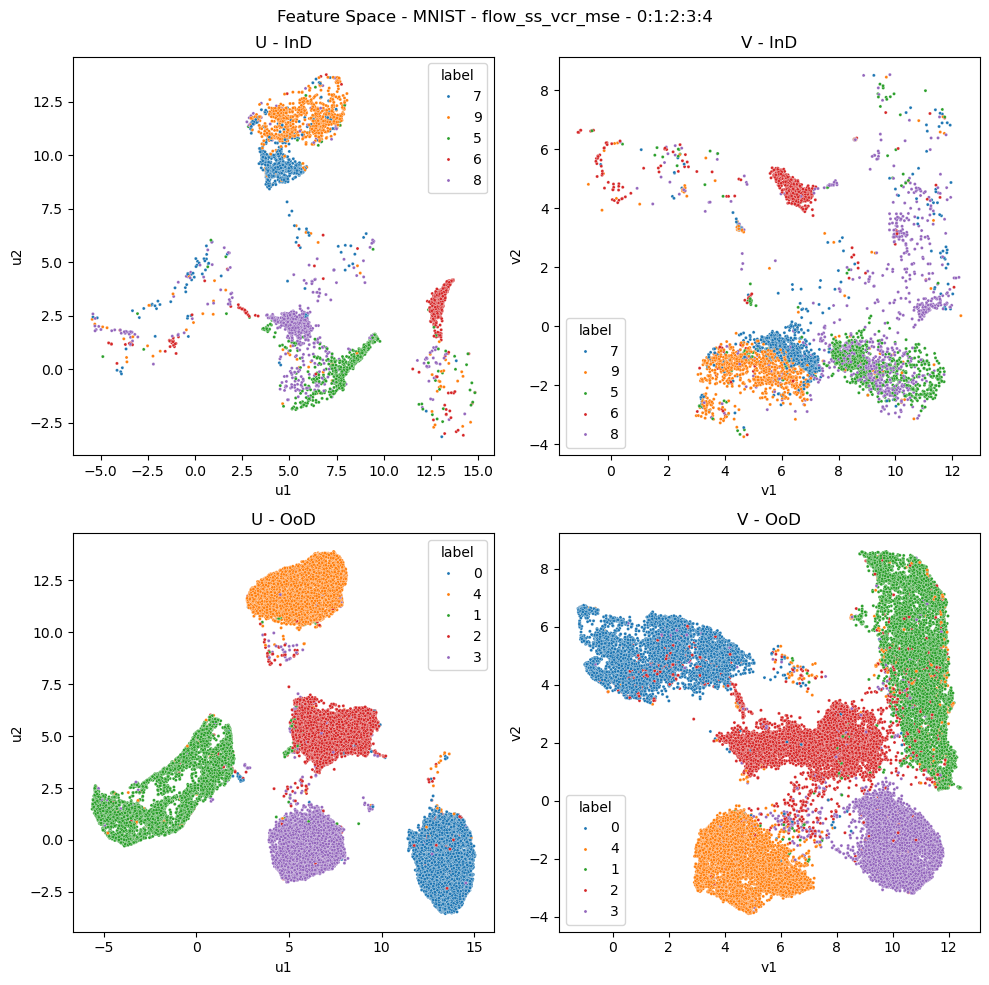

In [12]:
# plot feature space
ind_labels = [config.labels[i] for i in ind_tgt]
df_emb2d = pd.DataFrame()
u1, u2 = ind_e_u2d.T
v1, v2 = ind_e_v2d.T
df_emb2d = pd.concat([df_emb2d, pd.DataFrame(dict(u1=u1, u2=u2, v1=v1, v2=v2, label=ind_labels, source="ind"))])

if ood_str:
    ood_labels = [config.labels[i] for i in ood_tgt]
    u1, u2 = ood_e_u2d.T
    v1, v2 = ood_e_v2d.T
    df_emb2d = pd.concat([df_emb2d, pd.DataFrame(dict(u1=u1, u2=u2, v1=v1, v2=v2, label=ood_labels, source="ood"))])

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 10))
fig.suptitle(f"Feature Space - {dataset_name} - {model_name} - {ood_str}")
ax1.set_title("U - InD")
ax2.set_title("V - InD")
ax3.set_title("U - OoD")
ax4.set_title("V - OoD")
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ind")], x="u1", y="u2", hue="label", s=5, ax=ax1)
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ind")], x="v1", y="v2", hue="label", s=5, ax=ax2)
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ood")], x="u1", y="u2", hue="label", s=5, ax=ax3)
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ood")], x="v1", y="v2", hue="label", s=5, ax=ax4)
plt.tight_layout()
plt.show()

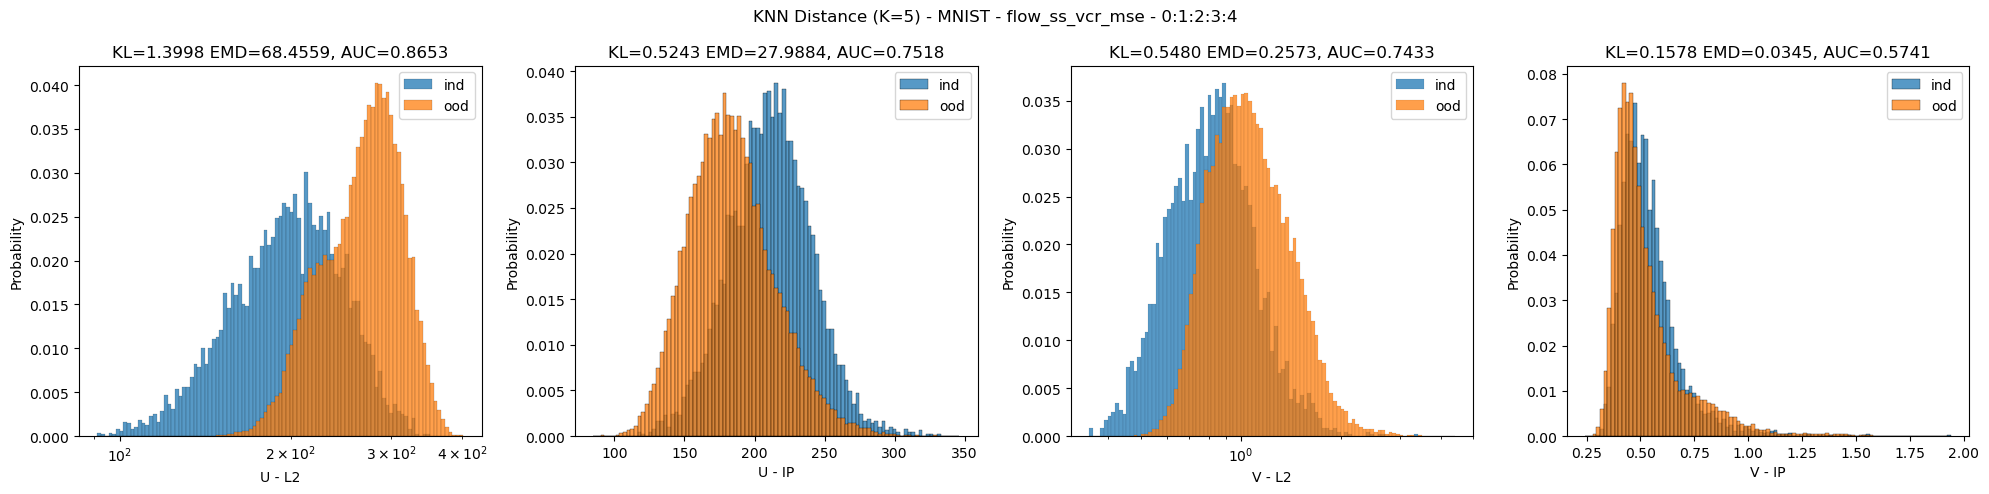

In [13]:
# plot knn distance from ind/ood to val data
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"KNN Distance (K=5) - {dataset_name} - {model_name} - {ood_str}")

def plot_knn_dists(index_fn, ax, idx_data, ind_data, ood_data=None, k=5, scale="linspace"):
    index = index_fn(idx_data.shape[-1])
    index.add(idx_data)
    Di = index.search(ind_data, k)[0].mean(-1)
    D = [Di]
    T = [[0] * Di.shape[0]]
    if ood_str:
        Do = index.search(ood_data, k)[0].mean(-1)
        D.append(Do)
        T.append([1] * Do.shape[0]) 
    D = np.concatenate(D, axis=0)
    T = np.concatenate(T, axis=0)
    if scale == "linspace":
        s, e = D.min(), D.max()
        bins = np.linspace(s, e, 100)
    if scale == "logspace":
        s, e = np.log10(D.min() + 1e-7), np.log10(D.max())
        bins = np.logspace(s, e, 100)
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    prefix = ""
    if ood_str:
        Ci = np.histogram(Di, bins, density=True)[0]
        Co = np.histogram(Do, bins, density=True)[0]
        kld = entropy(Co + 1e-7, Ci + 1e-7)
        emd = wasserstein_distance(Do, Di)
        auc = roc_auc_score(T, D)
        auc = max(auc, 1-auc)
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
        ax.set_title(f"KL={kld:.4f} EMD={emd:.4f}, AUC={auc:.4f}")
    if scale == "logspace":
        ax.set_xscale('log')
    ax.legend()

plot_knn_dists(faiss.IndexFlatL2, axs[0], val_e_u, ind_e_u, ood_e_u if ood_str else None, scale="logspace")
axs[0].set_xlabel("U - L2")
plot_knn_dists(faiss.IndexFlatIP, axs[1], val_e_u, ind_e_u, ood_e_u if ood_str else None, scale="linspace")
axs[1].set_xlabel("U - IP")
plot_knn_dists(faiss.IndexFlatL2, axs[2], val_e_v, ind_e_v, ood_e_v if ood_str else None, scale="logspace")
axs[2].set_xlabel("V - L2")
plot_knn_dists(faiss.IndexFlatIP, axs[3], val_e_v, ind_e_v, ood_e_v if ood_str else None, scale="linspace")
axs[3].set_xlabel("V - IP")
plt.tight_layout()
plt.show()

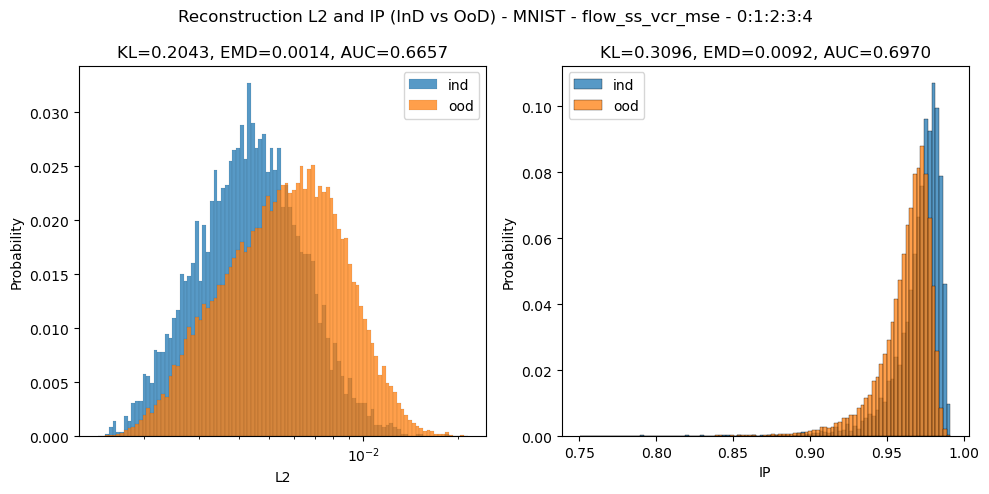

In [14]:
# plot reconstruction-based ood metrics
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

# data
_ind_inp = ind_inp.reshape((ind_inp.shape[0], -1))
_ind_rcn = ind_rcn.reshape((ind_inp.shape[0], -1))
# unit vectors
_ind_inp_unit = _ind_inp / (np.linalg.norm(_ind_inp, axis=-1, keepdims=True) + 1e-7)
_ind_rcn_unit = _ind_rcn / (np.linalg.norm(_ind_rcn, axis=-1, keepdims=True) + 1e-7)
# metrics
ind_rcn_l2 = ((_ind_inp - _ind_rcn) ** 2).mean(-1)
ind_rcn_ip = (_ind_inp_unit * _ind_rcn_unit).sum(-1)

if ood_str:
    # data
    _ood_inp = ood_inp.reshape((ood_inp.shape[0], -1))
    _ood_rcn = ood_rcn.reshape((ood_inp.shape[0], -1))
    # unit vectors
    _ood_inp_unit = _ood_inp / (np.linalg.norm(_ood_inp, axis=-1, keepdims=True) + 1e-7)
    _ood_rcn_unit = _ood_rcn / (np.linalg.norm(_ood_rcn, axis=-1, keepdims=True) + 1e-7)
    # metrics
    ood_rcn_l2 = ((_ood_inp - _ood_rcn) ** 2).mean(-1)
    ood_rcn_ip = (_ood_inp_unit * _ood_rcn_unit).sum(-1)

def plot_rcn(ind_rcn, ood_rcn, ax, scale="linspace"):
    D = ind_rcn
    if ood_str:
        D = np.concatenate([ind_rcn, ood_rcn], axis=0)
    if scale == "linspace":
        s, e = D.min(), D.max()
        bins = np.linspace(s, e, 100)
    if scale == "logspace":
        s, e = np.log10(D.min() + 1e-7), np.log10(D.max())
        bins = np.logspace(s, e, 100)
    sns.histplot(ind_rcn, label="ind", stat="probability", bins=bins, ax=ax)
    if ood_str:
        sns.histplot(ood_rcn, label="ood", stat="probability", bins=bins, ax=ax)
        T = np.concatenate([[0]*ind_rcn.shape[0],[1]*ood_rcn.shape[0]], axis=0)
        Ci = np.histogram(ind_rcn, bins, density=True)[0]
        Co = np.histogram(ood_rcn, bins, density=True)[0]
        kld = entropy(Co + 1e-7, Ci + 1e-7)
        emd = wasserstein_distance(ood_rcn, ind_rcn)
        auc = roc_auc_score(T, D)
        auc = max(auc, 1-auc)
        ax.set_title(f"KL={kld:.4f}, EMD={emd:.4f}, AUC={auc:.4f}")
    if scale == "logspace":
        ax.set_xscale("log")
    ax.legend()

plot_rcn(ind_rcn_l2, ood_rcn_l2 if ood_str else None, ax1, scale="logspace")
ax1.set_xlabel("L2")
plot_rcn(ind_rcn_ip, ood_rcn_ip if ood_str else None, ax2, scale="linspace")
ax2.set_xlabel("IP")
plt.suptitle(f"Reconstruction L2 and IP (InD vs OoD) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()

In [15]:
# compute vector norms
trn_n_u = np.linalg.norm(trn_e_u, axis=-1)
trn_n_v = np.linalg.norm(trn_e_v, axis=-1)
val_n_u = np.linalg.norm(val_e_u, axis=-1)
val_n_v = np.linalg.norm(val_e_v, axis=-1)
ind_n_u = np.linalg.norm(ind_e_u, axis=-1)
ind_n_v = np.linalg.norm(ind_e_v, axis=-1)
if ood_str:
    ood_n_u = np.linalg.norm(ood_e_u, axis=-1)
    ood_n_v = np.linalg.norm(ood_e_v, axis=-1)
rnd_n_u = np.linalg.norm(rnd_e_u, axis=-1)
rnd_n_v = np.linalg.norm(rnd_e_v, axis=-1)

print(trn_n_u.mean(), trn_n_u.std(), trn_n_v.mean(), trn_n_v.std())
print(val_n_u.mean(), val_n_u.std(), val_n_v.mean(), val_n_v.std())
print(ind_n_u.mean(), ind_n_u.std(), ind_n_v.mean(), ind_n_v.std())
if ood_str:
    print(ood_n_u.mean(), ood_n_u.std(), ood_n_v.mean(), ood_n_v.std())
print(rnd_n_u.mean(), rnd_n_u.std(), rnd_n_v.mean(), rnd_n_v.std())

17.517294 0.8093688 0.981658 0.13819079
17.475613 0.80093414 0.98295826 0.13830426
17.561352 0.8155576 0.97802615 0.13050039
17.73463 1.031388 1.0530448 0.16768119
25.85908 1.2405053 24.853283 0.742591


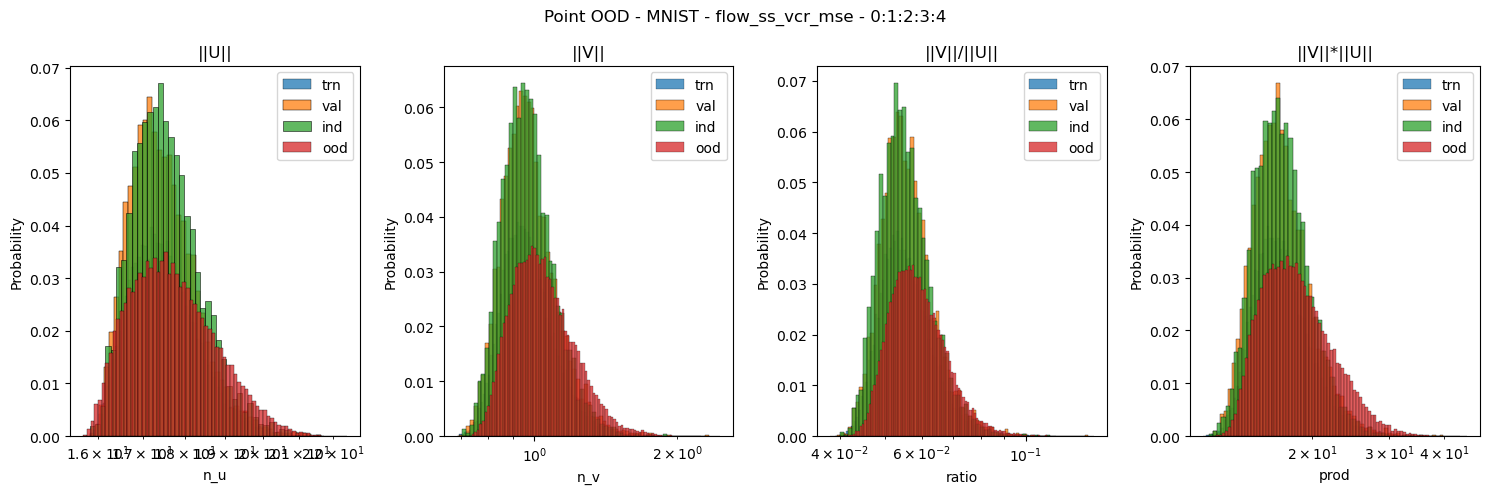

In [16]:
# plot pointwise ood metrics
df_trn = pd.DataFrame(dict(n_u=trn_n_u, n_v=trn_n_v, ratio=trn_n_v/trn_n_u, prod=trn_n_v*trn_n_u, target=trn_tgt))
df_val = pd.DataFrame(dict(n_u=val_n_u, n_v=val_n_v, ratio=val_n_v/val_n_u, prod=val_n_v*val_n_u, target=val_tgt))
df_ind = pd.DataFrame(dict(n_u=ind_n_u, n_v=ind_n_v, ratio=ind_n_v/ind_n_u, prod=ind_n_v*ind_n_u, target=ind_tgt))
if ood_str:
    df_ood = pd.DataFrame(dict(n_u=ood_n_u, n_v=ood_n_v, ratio=ood_n_v/ood_n_u, prod=ood_n_v*ood_n_u, target=ood_tgt))
df_rnd = pd.DataFrame(dict(n_u=rnd_n_u, n_v=rnd_n_v, ratio=rnd_n_v/rnd_n_u, prod=rnd_n_v*rnd_n_u))

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize = (15, 5))
fig.suptitle(f"Point OOD - {dataset_name} - {model_name} - {ood_str}")

def plot_row(prop, ax):
    sns.histplot(data=df_trn, x=prop, log_scale=True, fill=True, label='trn', stat='probability', ax=ax)
    sns.histplot(data=df_val, x=prop, log_scale=True, fill=True, label='val', stat='probability', ax=ax)
    sns.histplot(data=df_ind, x=prop, log_scale=True, fill=True, label='ind', stat='probability', ax=ax)
    if ood_str:
        sns.histplot(data=df_ood, x=prop, log_scale=True, fill=True, label='ood', stat='probability', ax=ax)
    # sns.histplot(data=df_rnd, x=prop, log_scale=True, fill=True, label='rnd', stat='probability', ax=ax)
    ax.legend()

plot_row("n_u", ax1)
plot_row("n_v", ax2)
plot_row("ratio", ax3)
plot_row("prod", ax4)
ax1.title.set_text('||U||')
ax2.title.set_text('||V||')
ax3.title.set_text('||V||/||U||')
ax4.title.set_text('||V||*||U||')

plt.tight_layout()
plt.show()

In [17]:
# organize data by class, aggregate groupwise
if ood_str:
    df_tst = pd.concat([df_ind, df_ood], axis=0)
else:
    df_tst = df_ind

all_targets = list(df_tst['target'].unique())
K = len(all_targets)
N = 128
rw, rh = 2, 0.75
colors = sns.color_palette(n_colors=K)

pointwise_trn = {}
pointwise_val = {}
pointwise_tst = {}

groupwise_trn = {}
groupwise_val = {}
groupwise_tst = {}

for i in range(K):
    _trn = df_trn[df_trn['target'] == all_targets[i]]
    _val = df_val[df_val['target'] == all_targets[i]]
    _tst = df_tst[df_tst['target'] == all_targets[i]]
    pointwise_trn[i] = _trn.copy()
    pointwise_val[i] = _val.copy()
    pointwise_tst[i] = _tst.copy()
    groupwise_trn[i] = _trn.rolling(N).agg(['mean', 'std']).dropna().copy()
    groupwise_val[i] = _val.rolling(N).agg(['mean', 'std']).dropna().copy()
    groupwise_tst[i] = _tst.rolling(N).agg(['mean', 'std']).dropna().copy()


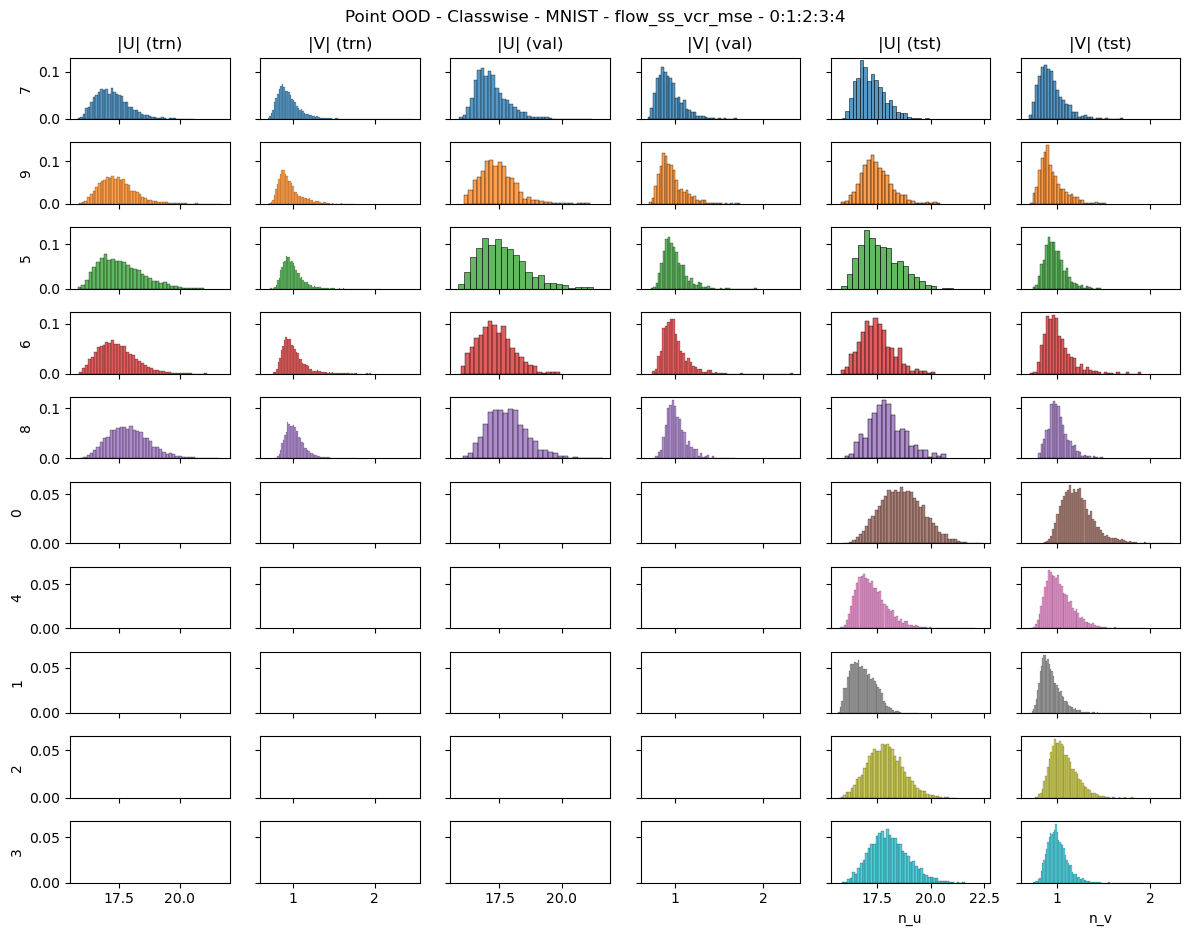

In [18]:
# plot per-class pointwise ood metrics
fig, axs = plt.subplots(K, 6, figsize=(6*rw, K*rh+2), sharex='col', sharey='row')
fig.suptitle(f"Point OOD - Classwise - {dataset_name} - {model_name} - {ood_str}")

for i in range(K):
    _trn = pointwise_trn[i]
    _val = pointwise_val[i]
    _tst = pointwise_tst[i]
    _tgt = all_targets[i]
    _label = config.labels[_tgt]
    _hue = colors[i]
    (ax1, ax2, ax3, ax4, ax5, ax6) = axs[i]
    ax1.set_ylabel(_label)
    if len(_trn) > 0:
        sns.histplot(data=_trn, x="n_u", fill=True, legend=False, color=_hue, stat='probability', ax=ax1)
        sns.histplot(data=_trn, x="n_v", fill=True, legend=False, color=_hue, stat='probability', ax=ax2)
    if len(_val) > 0:
        sns.histplot(data=_val, x="n_u", fill=True, legend=False, color=_hue, stat='probability', ax=ax3)
        sns.histplot(data=_val, x="n_v", fill=True, legend=False, color=_hue, stat='probability', ax=ax4)
    if len(_tst) > 0:
        sns.histplot(data=_tst, x="n_u", fill=True, legend=False, color=_hue, stat='probability', ax=ax5)
        sns.histplot(data=_tst, x="n_v", fill=True, legend=False, color=_hue, stat='probability', ax=ax6)

axs[0][0].title.set_text('|U| (trn)')
axs[0][1].title.set_text('|V| (trn)')
axs[0][2].title.set_text('|U| (val)')
axs[0][3].title.set_text('|V| (val)')
axs[0][4].title.set_text('|U| (tst)')
axs[0][5].title.set_text('|V| (tst)')

plt.tight_layout()
plt.show()

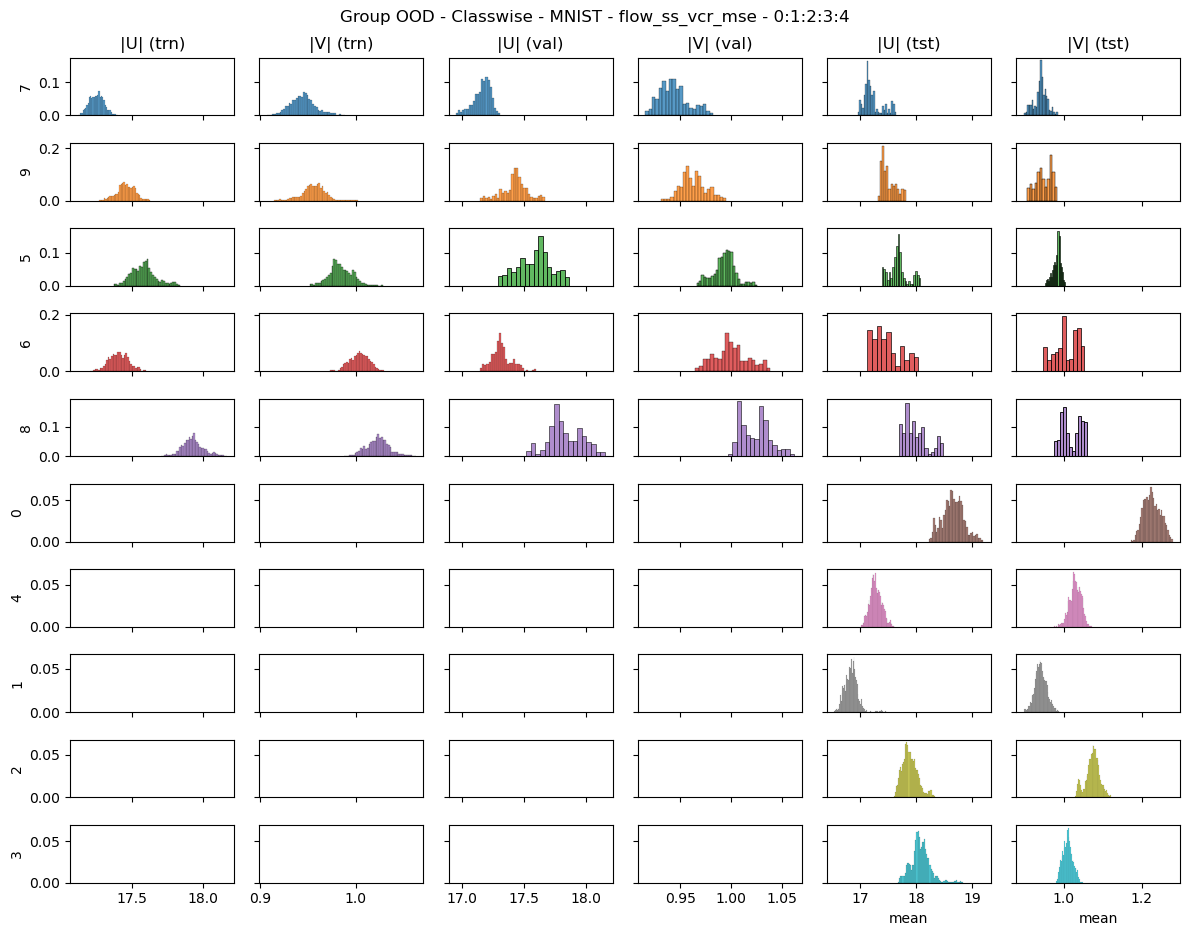

In [19]:
# plot per-class groupwise ood metrics
fig, axs = plt.subplots(K, 6, figsize = (6*rw, K*rh+2), sharex='col', sharey='row')
fig.suptitle(f"Group OOD - Classwise - {dataset_name} - {model_name} - {ood_str}")

for i in all_targets:
    _trn = groupwise_trn[i]
    _val = groupwise_val[i]
    _tst = groupwise_tst[i]
    _tgt = all_targets[i]
    _label = config.labels[_tgt]
    _hue = colors[i]
    (ax1, ax2, ax3, ax4, ax5, ax6) = axs[i]
    ax1.set_ylabel(_label)
    if len(_trn) > 0:
        sns.histplot(data=_trn.n_u, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax1)
        sns.histplot(data=_trn.n_v, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax2)
    if len(_val) > 0:
        sns.histplot(data=_val.n_u, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax3)
        sns.histplot(data=_val.n_v, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax4)
    if len(_tst) > 0:
        sns.histplot(data=_tst.n_u, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax5)
        sns.histplot(data=_tst.n_v, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax6)

axs[0][0].title.set_text('|U| (trn)')
axs[0][1].title.set_text('|V| (trn)')
axs[0][2].title.set_text('|U| (val)')
axs[0][3].title.set_text('|V| (val)')
axs[0][4].title.set_text('|U| (tst)')
axs[0][5].title.set_text('|V| (tst)')

plt.tight_layout()
plt.show()